In [1]:
!pip install --upgrade tensorflow


In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Displaying images from the training set:


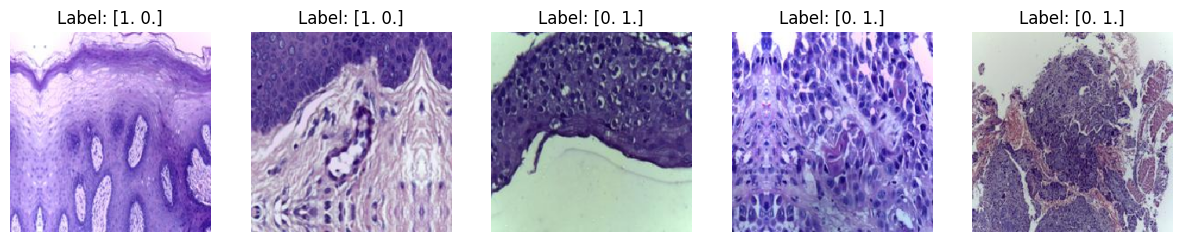

Displaying images from the validation set:


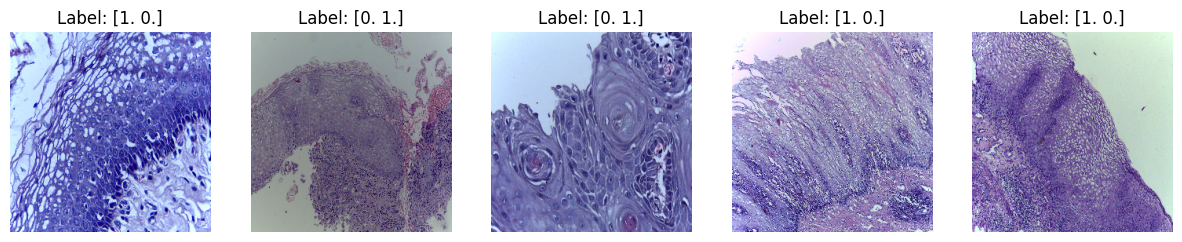

In [4]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set your dataset paths
train_dir = "/content/drive/MyDrive/archive (5)/train"
validation_dir = "/content/drive/MyDrive/archive (5)/val"

# Set your image size
img_size = (256, 256)

# Create data generators for training and validation sets
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=32,
    class_mode='categorical'
)

# Display images from the training set in matrix box form
print("Displaying images from the training set:")
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    img, label = train_generator.next()
    axes[i].imshow(img[0])
    axes[i].set_title(f"Label: {label[0]}")
    axes[i].axis('off')

plt.show()

# Display images from the validation set in matrix box form
print("Displaying images from the validation set:")
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    img, label = validation_generator.next()
    axes[i].imshow(img[0])
    axes[i].set_title(f"Label: {label[0]}")
    axes[i].axis('off')

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Custom Self-Attention Layer
class SelfAttention(layers.Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units
        self.W_q = layers.Dense(units)
        self.W_k = layers.Dense(units)
        self.W_v = layers.Dense(units)
        self.attention = layers.Attention()

    def call(self, inputs):
        query = self.W_q(inputs)
        key = self.W_k(inputs)
        value = self.W_v(inputs)
        attention_output = self.attention([query, key, value])
        return attention_output

def inverted_residual_block(inputs, num_filters, strides=1, expansion_ratio=1):
    ## Point-Wise Convolution
    x = layers.Conv2D(
        filters=expansion_ratio*inputs.shape[-1],
        kernel_size=1,
        padding="same",
        use_bias=False
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    ## Depth-Wise Convolution
    x = layers.DepthwiseConv2D(
        kernel_size=3,
        strides=strides,
        padding="same",
        use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    ## Point-Wise Convolution
    x = layers.Conv2D(
        filters=num_filters,
        kernel_size=1,
        padding="same",
        use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)

    ## Residual Connection
    if strides == 1 and (inputs.shape == x.shape):
        return layers.Add()([inputs, x])
    return x

def mlp(x, mlp_dim, dim, dropout_rate=0.1):
    x = layers.Dense(mlp_dim, activation="swish")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(dim)(x)
    x = layers.Dropout(dropout_rate)(x)
    return x

def transformer_encoder(x, num_heads, dim, mlp_dim):
    skip_1 = x
    x = layers.LayerNormalization()(x)
    x = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=dim
    )(x, x)
    x = layers.Add()([x, skip_1])

    skip_2 = x
    x = layers.LayerNormalization()(x)
    x = mlp(x, mlp_dim, dim)
    x = layers.Add()([x, skip_2])

    return x

def mobile_vit_block(inputs, num_filters, dim, patch_size=2, num_layers=1):
    B, H, W, C = inputs.shape

    ## 3x3 conv
    x = layers.Conv2D(
        filters=C,
        kernel_size=3,
        padding="same",
        use_bias=False
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    ## 1x1 conv: d-dimension
    x = layers.Conv2D(
        filters=dim,
        kernel_size=1,
        padding="same",
        use_bias=False
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    ## Reshape x to flattened patches
    P = patch_size*patch_size
    N = int(H*W//P)
    x = layers.Reshape((P, N, dim))(x)

    ## Transformr Encoder
    for _ in range(num_layers):
        x = transformer_encoder(x, 1, dim, dim*2)

    ## Reshape
    x = layers.Reshape((H, W, dim))(x)

    ## 1x1 conv: C-dimension
    x = layers.Conv2D(
        filters=C,
        kernel_size=1,
        padding="same",
        use_bias=False
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    ## Concatenation
    x = layers.Concatenate()([x, inputs])

    ## 3x3 conv
    x = layers.Conv2D(
        filters=num_filters,
        kernel_size=3,
        padding="same",
        use_bias=False
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    return x

def MobileViT(input_shape, num_classes):
    num_channels = [16, 16, 24, 24, 24, 48, 64, 64, 80, 80, 96, 320]
    dim = [64, 80, 96]
    expansion_ratio = 2

    # Input layer
    inputs = layers.Input(input_shape)

    # Stem
    x = layers.Conv2D(
        filters=num_channels[0],
        kernel_size=3,
        strides=2,
        padding="same",
        use_bias=False
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)
    x = inverted_residual_block(x, num_channels[1], strides=1, expansion_ratio=expansion_ratio)

    # Stage 1
    x = inverted_residual_block(x, num_channels[2], strides=2, expansion_ratio=expansion_ratio)
    x = inverted_residual_block(x, num_channels[3], strides=1, expansion_ratio=expansion_ratio)
    x = inverted_residual_block(x, num_channels[4], strides=1, expansion_ratio=expansion_ratio)

    # Stage 2
    x = inverted_residual_block(x, num_channels[5], strides=2, expansion_ratio=expansion_ratio)
    x = mobile_vit_block(x, num_channels[6], dim[0], num_layers=1)

    # Stage 3
    x = inverted_residual_block(x, num_channels[7], strides=2, expansion_ratio=expansion_ratio)
    x = mobile_vit_block(x, num_channels[8], dim[1], num_layers=4)

    # Stage 4
    x = inverted_residual_block(x, num_channels[9], strides=2, expansion_ratio=expansion_ratio)
    x = mobile_vit_block(x, num_channels[10], dim[2], num_layers=3)
    x = layers.Conv2D(
        filters=num_channels[11],
        kernel_size=1,
        padding="same",
        use_bias=False
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("swish")(x)

    # Classifier
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.models.Model(inputs, outputs)
    return model

if __name__ == "__main__":
    # Set your dataset paths
    train_dir = "/content/drive/MyDrive/archive (5)/train"
    validation_dir = "/content/drive/MyDrive/archive (5)/val"
    test_dir = "/content/drive/MyDrive/archive (5)/test"

    # Set your image size and number of classes
    img_size = (256, 256)
    num_classes = 2

    # Create data generators with data augmentation for the training set
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical'
    )

    # Build and compile the MobileViT model
    model = MobileViT(input_shape=(*img_size, 3), num_classes=num_classes)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(train_generator, epochs=10, validation_data=validation_generator)

    # Evaluate on the test set
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical'
    )

    loss, accuracy = model.evaluate(test_generator)
    print(f'Test accuracy: {accuracy}')


Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Epoch 1/10
155/155 [==============================] - 903s 6s/step - loss: 0.5747 - accuracy: 0.7002 - val_loss: 0.8004 - val_accuracy: 0.2333
Epoch 2/10
155/155 [==============================] - 860s 6s/step - loss: 0.4709 - accuracy: 0.7729 - val_loss: 0.8778 - val_accuracy: 0.2333
Epoch 3/10
155/155 [==============================] - 873s 6s/step - loss: 0.4366 - accuracy: 0.7974 - val_loss: 2.0624 - val_accuracy: 0.2333
Epoch 4/10
155/155 [==============================] - 905s 6s/step - loss: 0.3936 - accuracy: 0.8267 - val_loss: 0.7291 - val_accuracy: 0.6417
Epoch 5/10
155/155 [==============================] - 927s 6s/step - loss: 0.3782 - accuracy: 0.8275 - val_loss: 0.5611 - val_accuracy: 0.7667
Epoch 6/10
155/155 [==============================] - 934s 6s/step - loss: 0.3500 - accuracy: 0.8467 - val_loss: 0.4322 - val_accuracy: 0.8417
Epoch 7/10
155/155 [==============================] - 991s 

In [ ]:
# Save the entire model
model.save("/content/drive/MyDrive/your_model_name.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Calculate Precision, Recall, F1-Score, and Accuracy
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Binarize the labels for ROC and PR curves
n_classes = num_classes
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
y_pred_bin = label_binarize(y_pred, classes=np.arange(n_classes))


Precision: 0.6679
Recall: 0.7143
F1-Score: 0.6824
Accuracy: 0.7143
